# Convolutional Neural Networks & Computer Vision

Computer vision offers a way to take real world images, and computationally analyze to predict and find patterns within visual data. For instance, the camera of a Self-Driving car.

* https://en.wikipedia.org/wiki/Convolutional_neural_network

Why can't this be done using normal Feed-Forward Neural Networks? Simple, the first step in analyzing an image with Feed Forward Neural Nets, you need to flatten the image to a single vector. For instance, a 28 x 28 pixel image flattens to a vector of length, 784. This is an extremely small image, and the inputs is of length 784. This is problematic with larger images because for the deep neural network to analyze, because there will be an extremely high number of weights to populate, and makes identifying patterns an extremly complex task.

The purpose of this notebook is to dig into Convolutional Neural Network architectures through analyzing a commonly used dataset, Food-101. The Food-101 dataset is commonly associated with CNN models because it offers a large dataset that can be used to analyze and predict images to determine the type of food the image represents.

* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

For this specific notebook, I am going to look at a condensed dataset consisting of the list below for a simple Multi-Class Classification problem.

1. Chicken Curry
2. Chicken Wings
3. Fried Rice
4. Grilled Salmon
5. Hamburger
6. Ice Cream
7. Pizza
8. Ramen
9. Steak
10. Sushi

## Imports

In [1]:
import datetime
import logging
import os
import pathlib
import random
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from py_learning_toolbox import ml_toolbox
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [2]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-09-19 11:04:27.047121


In [3]:
tf.__version__

'2.13.0'

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [6]:
RANDOM_SEED = 42

## Downloading, Analyzing, & Creating Datasets

The dataset used is the Food 101 dataset commonly used to to explore Computer Vision. For simplicity of getting started with Computer Vision, I am only going to be looking at two image classes to work quickly with a smaller dataset before applying learnings to the larger dataset.

* https://www.kaggle.com/datasets/dansbecker/food-101 (original kaggle page of dataset)
* https://github.com/mrdbourke/tensorflow-deep-learning/ (getting the modified dataset)

### Downloading & Analyzing Data

In [7]:
# Image dataset location
data_directory = pathlib.Path('./data/food-101/10_food_classes_all_data')
test_directory = data_directory / 'test'
train_directory = data_directory / 'train'

In [8]:
ml_toolbox.analysis.image.summarize_directory(data_directory)

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/ice_cream Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/chicken_curry Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/steak Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/sushi Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/chicken_wings Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/grilled_salmon Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/hamburger Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Direct

In [9]:
class_names = ml_toolbox.analysis.image.get_classnames_from_directory(train_directory)
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Chicken_curry - Image Shape: (512, 512, 3)


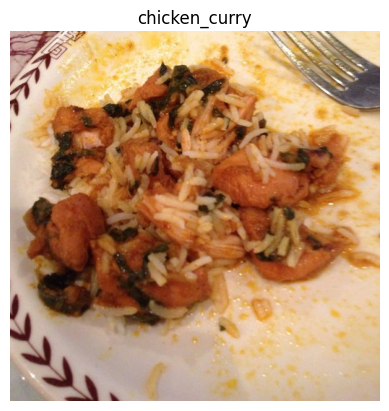

In [10]:
# Lets look at some images
img = ml_toolbox.analysis.image.plot_random_image_from_directory(train_directory, random.choice(class_names))

### Creating Datasets

In [11]:
# Constants
SCALE = 1. / 255
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [12]:
# Creating data generators
train_data_gen = ImageDataGenerator(rescale=SCALE)
train_data_augmented_gen = ImageDataGenerator(rescale=SCALE,
                                              rotation_range=0.2,
                                              width_shift_range=0.2,
                                              height_shift_range=0.2,
                                              zoom_range=0.2,
                                              horizontal_flip=True)

test_data_gen = ImageDataGenerator(rescale=SCALE)

In [13]:
# Loading data in batches
train_data = train_data_gen.flow_from_directory(str(train_directory),
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical')

train_data_augmented = train_data_augmented_gen.flow_from_directory(str(train_directory),
                                                          target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

test_data = test_data_gen.flow_from_directory(str(test_directory),
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',
                                              shuffle=False)

Found 7500 images belonging to 10 classes.
Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Experiments

To analyze this dataset, I am going to go through a handful of separate experiments.

* Experiment-0: Baseline Model
* Experiment-1: Simplified Baseline Model
* Experiment-2: Baseline Model w/ Data Augmentation

### Experiment Constants

In [14]:
OUTPUT_SIZE = 10

TRAIN_STEPS_PER_EPOCH = len(train_data)
VAL_STEPS_PER_EPOCH = len(test_data)

EPOCHS = 5

### Experiment-0: Baseline Model

We've been takling a lot wabout the CNN explainer website. They've been using 10 classes as well, so lets start out with creating our baseline model using the same architecture they use.

* https://poloclub.github.io/cnn-explainer/

In [15]:
# Constants
model_0_name = 'model_0_baseline'

In [16]:
# Set seed
tf.random.set_seed(RANDOM_SEED)

# Create Model (same as in CNN explainer)
model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                           name='InputLayer'),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax', name='OutputLayer'),
], name=model_0_name)

# Compile Model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit Model
model_0_history = model_0.fit(train_data,
                              epochs=EPOCHS,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_data=test_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
235/235 [==============================] - 73s 308ms/step - loss: 2.1632 - accuracy: 0.1984 - val_loss: 2.0300 - val_accuracy: 0.2696
Epoch 2/5
235/235 [==============================] - 73s 310ms/step - loss: 1.9646 - accuracy: 0.3131 - val_loss: 1.9576 - val_accuracy: 0.3088
Epoch 3/5
235/235 [==============================] - 73s 311ms/step - loss: 1.6944 - accuracy: 0.4201 - val_loss: 1.9730 - val_accuracy: 0.3276
Epoch 4/5
235/235 [==============================] - 74s 313ms/step - loss: 1.1915 - accuracy: 0.5984 - val_loss: 2.2642 - val_accuracy: 0.3084
Epoch 5/5
235/235 [==============================] - 74s 313ms/step - loss: 0.4995 - accuracy: 0.8477 - val_loss: 3.2768 - val_accuracy: 0.2828


In [17]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 3.2768 - accuracy: 0.2828


[3.276839017868042, 0.28279998898506165]

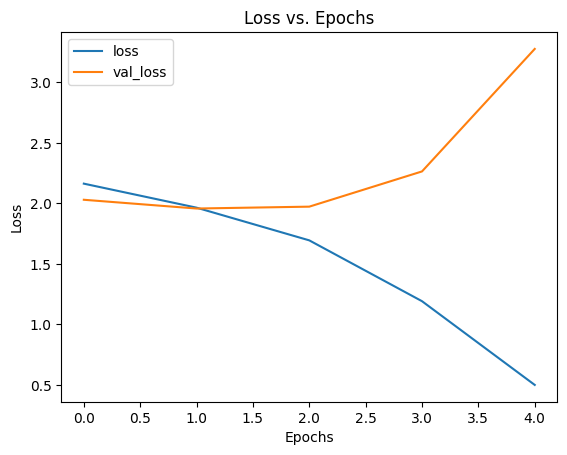

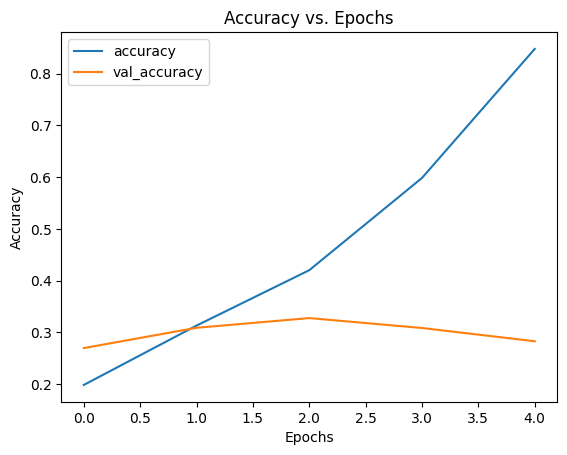

In [18]:
ml_toolbox.analysis.history.plot_history(model_0_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_0_history, metric='accuracy')

In [19]:
model_0_pred_probs = model_0.predict(test_data)
model_0_preds = tf.argmax(model_0_pred_probs, axis=1)

model_0_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_data.classes, model_0_preds, name=model_0_name)
model_0_results

79/79 [==============================] - 6s 80ms/step


ClassificationPredictionMetrics(accuracy=0.2828, precision=0.2985969347461727, recall=0.2828, f1=0.2782809309046886, name='model_0_baseline')

#### Findings

From the loss curves, it the validation loss starts to increase when the training loss decreases, indicating that the model is overfitting. Next steps to adjust overfitting is to introduce data augmentation, regularization, etc.

Ways of adjusting the model for overfitting:

1. Get more data. This allows for more opportunity to learn diverse patterns.
2. Simplify the model. Remove layers, filters, etc.
3. Data Augmentation. Data augmentation manipulates the training data in such a way to add more diversity to it without altering the original data.
4. Transfer Learning: Transf er learning leverages the patterens another model has similar data that has been fitted for, and we can use those patterns on our model.

### Experiment-1: Adjust for Overfitting by Simplifying Model (Removing Layers)

Cutting out the two Conv2D layers before the MaxPool

In [20]:
# Constants
model_1_name = 'model_1_simplified_baseline'

In [21]:
# Set seed
tf.random.set_seed(RANDOM_SEED)

# Create Model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                           name='InputLayer'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax', name='OutputLayer'),
], name=model_1_name)

# Compile Model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit Model
model_1_history = model_1.fit(train_data,
                              epochs=EPOCHS,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_data=test_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
235/235 [==============================] - 32s 134ms/step - loss: 2.1747 - accuracy: 0.2096 - val_loss: 2.0582 - val_accuracy: 0.2636
Epoch 2/5
235/235 [==============================] - 32s 135ms/step - loss: 1.7632 - accuracy: 0.4037 - val_loss: 1.9545 - val_accuracy: 0.3148
Epoch 3/5
235/235 [==============================] - 32s 135ms/step - loss: 1.2322 - accuracy: 0.6048 - val_loss: 2.1505 - val_accuracy: 0.2936
Epoch 4/5
235/235 [==============================] - 32s 135ms/step - loss: 0.6922 - accuracy: 0.7965 - val_loss: 2.7102 - val_accuracy: 0.2616
Epoch 5/5
235/235 [==============================] - 32s 138ms/step - loss: 0.3349 - accuracy: 0.9113 - val_loss: 3.2011 - val_accuracy: 0.2792


In [22]:
model_1.summary()

Model: "model_1_simplified_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Conv2D)         (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 29160)             0         
                                                                 
 OutputLayer (Dense)         (None, 10)

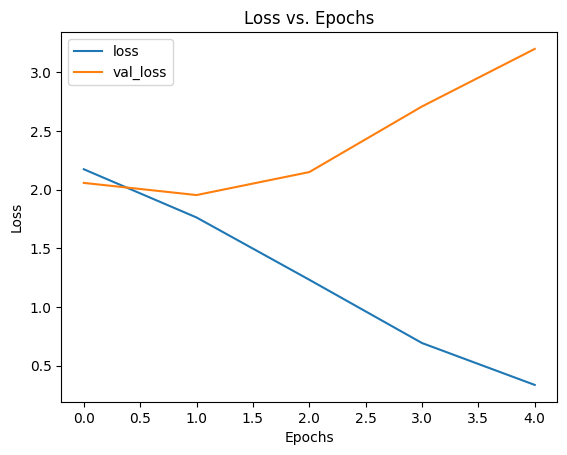

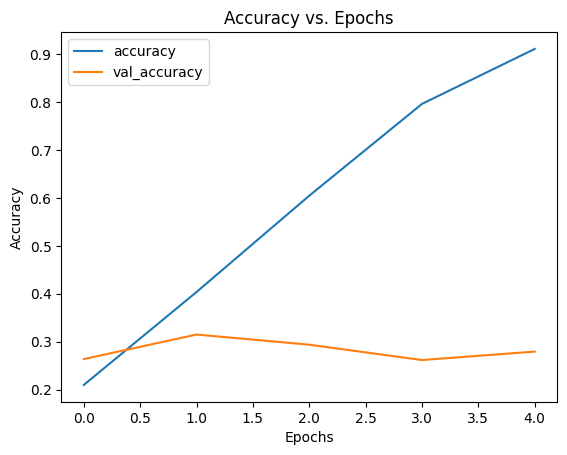

In [23]:
ml_toolbox.analysis.history.plot_history(model_1_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_1_history, metric='accuracy')

In [24]:
model_1_pred_probs = model_1.predict(test_data)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

model_1_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_data.classes, model_1_preds, name=model_1_name)
model_1_results

79/79 [==============================] - 6s 76ms/step


ClassificationPredictionMetrics(accuracy=0.2792, precision=0.2770212191112651, recall=0.2792, f1=0.2760724877029672, name='model_1_simplified_baseline')

#### Findings

From the loss curves, the accuracy went down and overfitting remained. Next step is to adjust the overfitting of the baseline model with data augmentation.

### Experiment-2: Addressing Overfitting Using Data Augmentation

Trying to reduce overitting with data augmentation. Ideally, we want to:
* Reduce overfitting
* Increase validation accuracy

In [25]:
# Constants
model_2_name = 'model_2_augmented_data'

In [26]:
# Set seed
tf.random.set_seed(RANDOM_SEED)

# Create Model (using clone model for quick)
model_2 = tf.keras.models.clone_model(model_0)
model_2._name = model_2_name

# Compile Model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit Model
model_2_history = model_2.fit(train_data,
                              epochs=EPOCHS,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                              validation_data=test_data,
                              validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/5
235/235 [==============================] - 75s 317ms/step - loss: 2.1399 - accuracy: 0.2195 - val_loss: 1.9448 - val_accuracy: 0.3012
Epoch 2/5
235/235 [==============================] - 74s 316ms/step - loss: 1.8261 - accuracy: 0.3751 - val_loss: 1.8416 - val_accuracy: 0.3660
Epoch 3/5
235/235 [==============================] - 74s 316ms/step - loss: 1.4505 - accuracy: 0.5213 - val_loss: 1.9231 - val_accuracy: 0.3612
Epoch 4/5
235/235 [==============================] - 74s 317ms/step - loss: 0.8155 - accuracy: 0.7388 - val_loss: 2.4149 - val_accuracy: 0.3092
Epoch 5/5
235/235 [==============================] - 75s 318ms/step - loss: 0.3096 - accuracy: 0.9073 - val_loss: 3.4148 - val_accuracy: 0.2880


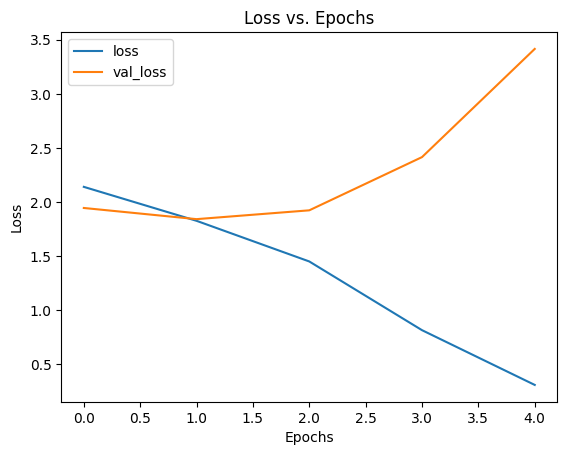

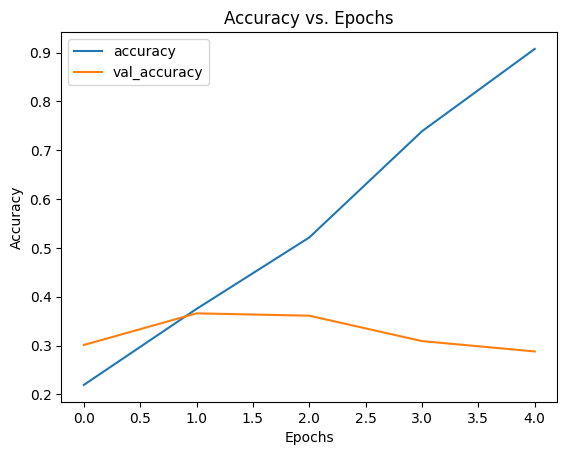

In [27]:
ml_toolbox.analysis.history.plot_history(model_2_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_2_history, metric='accuracy')

In [28]:
model_2_pred_probs = model_2.predict(test_data)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

model_2_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_data.classes, model_2_preds, name=model_2_name)
model_2_results

79/79 [==============================] - 7s 83ms/step


ClassificationPredictionMetrics(accuracy=0.288, precision=0.29328569862721676, recall=0.288, f1=0.28453703858115675, name='model_2_augmented_data')

#### Findings:

The loss curve looks significantly better! The loss curves resemble each other much better, and are still increasing after epoch 5, so more epochs would likely result in a better accuracy. How else can we experiment to improve this accuracy?

* Adjust model architecture
* Adjust augmentation hyper parameters.
* Train for longer
* Adjust learning rate.
* Try Transfer Learning

## Analysis

Now that I have performed a handful of experiments, I want to look more into all of the models to see how each one performed.

In [29]:
all_results = [
    model_0_results,
    model_1_results,
    model_2_results,
]

results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_results)
results_df

,accuracy,precision,recall,f1
model_0_baseline,0.2828,0.298597,0.2828,0.278281
model_1_simplified_baseline,0.2792,0.277021,0.2792,0.276072
model_2_augmented_data,0.2880,0.293286,0.2880,0.284537


<Axes: >

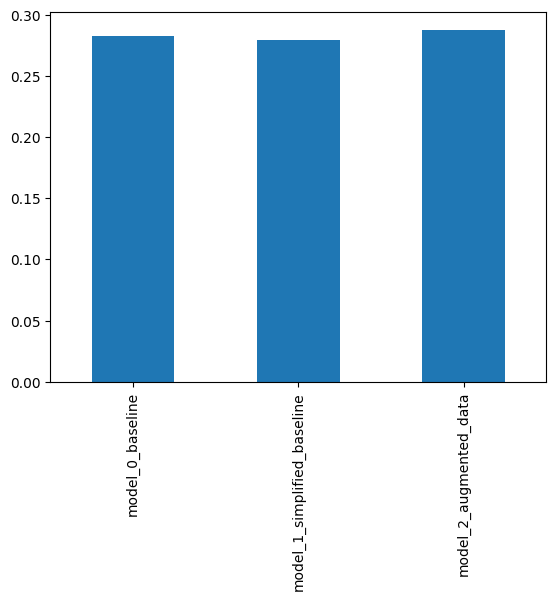

In [30]:
results_df['accuracy'].plot(kind='bar')

## Testing Model

To actually see the best model work, I am going to run some tests on custom images to see how well the predictions are when comparing against completely new images.

In [31]:
# Test Image location
test_image_directory = pathlib.Path('./data/food-101/model_testing')
steak_filename = test_image_directory / 'steak' / 'steak-and-eggs.jpeg'
steak_filename

PosixPath('data/food-101/model_testing/steak/steak-and-eggs.jpeg')

In [32]:
# Load and prep image
steak = ml_toolbox.preprocessing.image.load_and_resize_image(str(steak_filename))

1/1 [==============================] - 0s 34ms/step


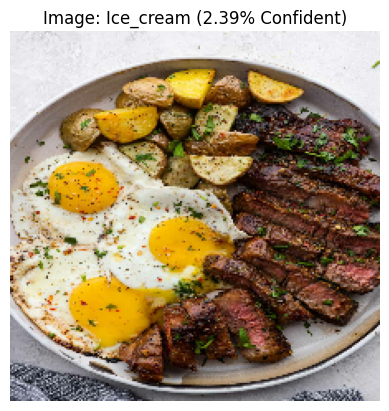

In [33]:
# get_predicted_class(model_2, str(steak_filename), class_names)
ml_toolbox.analysis.image.predict_and_plot_image(model_2, steak, class_names)

## Saving Model

After running through the analysis, I found that Experiment-2 was the best performing model. The next step is to export this model and verify that the model is correct.

In [34]:
filepath = f'./models/food_101_10_classes/{model_2_name}'

In [35]:
model_2.save(filepath)

INFO:tensorflow:Assets written to: ./models/model_2_augmented_data/assets
INFO:tensorflow:Assets written to: ./models/model_2_augmented_data/assets


In [36]:
loaded_model_2 = tf.keras.models.load_model(filepath)

In [37]:
loaded_model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 3.4148 - accuracy: 0.2880


[3.4147582054138184, 0.2879999876022339]

In [38]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 80ms/step - loss: 3.4148 - accuracy: 0.2880


[3.4147582054138184, 0.2879999876022339]